In [10]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
import torch
from torch_geometric.data import Data

In [11]:
import pandas as pd
df=pd.read_csv(r"C:\Users\tubaid\Desktop\updated data\final\Final_skill_to_skill.csv")

In [12]:
df.head(2)

,SkillId,PreReqs,label,Encoded_SkillId,Encoded_PreReqs
0,247,940,1,1,184
1,247,7727,1,1,494


In [13]:
skillid=df.Encoded_SkillId.tolist()
preq=df.Encoded_PreReqs.tolist()

In [14]:
edge_index = torch.tensor([preq,skillid], dtype=torch.long)

In [15]:
edge_index

tensor([[184, 494,   2,  ..., 578, 577, 512],
        [  1,   1,   1,  ..., 577, 578, 579]])

In [16]:
label=df.label.tolist()

In [17]:
label = torch.tensor(label, dtype=torch.float)

In [18]:
# import torch
# from torch_geometric.data import Data

dt=Data(y=label, edge_index=edge_index)

In [19]:
dt.edge_index

tensor([[184, 494,   2,  ..., 578, 577, 512],
        [  1,   1,   1,  ..., 577, 578, 579]])

In [20]:
dt

Data(edge_index=[2, 1756], y=[1756])

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(dt.edge_index, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

In [22]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

In [23]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([14960, 10]) torch.Size([14960, 10])


In [24]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [25]:
idx

0

In [26]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [27]:
pos_rw

tensor([[294, 484, 509,  ..., 484, 293, 240],
        [500, 499, 500,  ..., 499, 500, 499],
        [ 79,  80, 361,  ..., 365, 361, 445],
        ...,
        [310, 575, 574,  ..., 573, 572, 573],
        [212, 208, 212,  ..., 176, 174, 526],
        [513, 555, 513,  ..., 514, 513, 514]])

In [28]:
neg_rw

tensor([[294,   7, 516,  ..., 334, 390,  32],
        [500, 367, 218,  ..., 507, 257, 169],
        [ 79, 467, 545,  ..., 394, 288, 336],
        ...,
        [307,  70, 322,  ..., 153, 238, 501],
        [168, 203, 216,  ..., 498, 319, 542],
        [536, 550,  22,  ..., 571,  31, 329]])

In [29]:
import networkx as nx 
edge_tuples = [tuple(x) for x in dt.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

[258, 257, 482, 236, 257, 455, 260, 524, 564, 559]


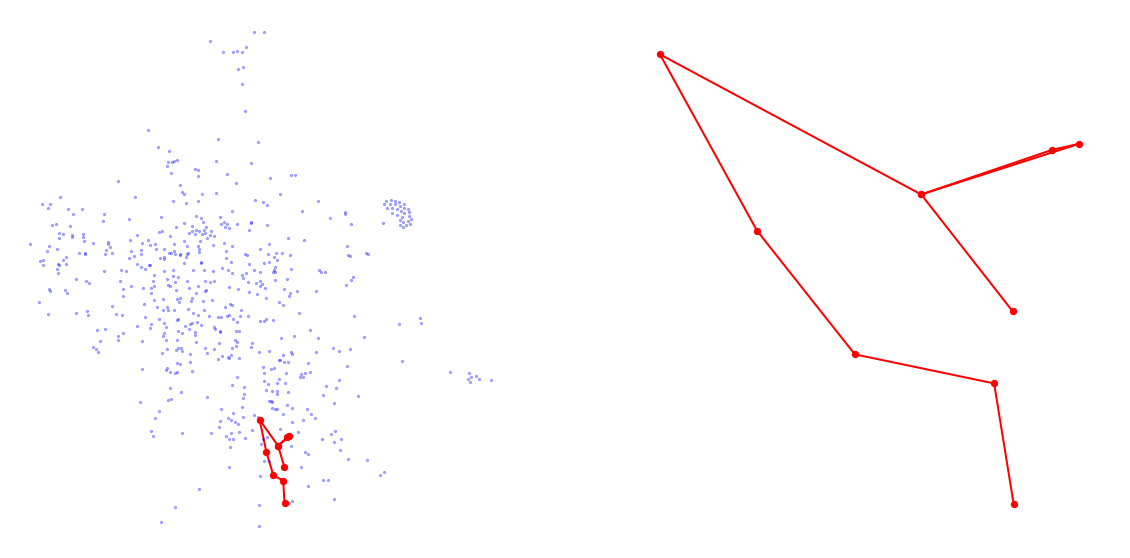

In [30]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
print(nodelist)
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

In [31]:
model = Node2Vec(dt.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [32]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [33]:
### Test function

In [34]:
dt

Data(edge_index=[2, 1756], y=[1756])

In [35]:
dt.y

tensor([1., 1., 0.,  ..., 0., 1., 1.])

In [36]:
dt.y.unique()

tensor([0., 1.])

In [37]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[dt.train_mask], dt.y[data.train_mask],
                     z[dt.test_mask], dt.y[data.test_mask],
                     max_iter=150)
    return acc

In [38]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

In [42]:
import networkx as nx
from node2vec import Node2Vec

In [40]:
!pip install node2vec

  Using cached node2vec-0.4.5-py3-none-any.whl (7.0 kB)


In [41]:
graph= nx.read_adjlist(r"C:\Users\tubaid\Desktop\usman.adjlist", nodetype=int)

In [ ]:


# Create a graph
graph = nx.fast_gnp_random_graph(n=100, p=0.5)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)